In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2
import json

### Load Train, Validation & Test Datasets

In [11]:
# Define paths
train_dir = "../data/ZhangLabData/CellData/OCT/train"
test_dir = "../data/ZhangLabData/CellData/OCT/test"

# Define image size & batch size
IMG_SIZE = (299, 299)  # Xception input size
BATCH_SIZE = 32
SEED = 42  # Ensures reproducibility

In [12]:
# Get class names from train directory
class_names = sorted(os.listdir(train_dir))

# Function to count images in each class
def count_images(directory):
    class_counts = {class_name: len(os.listdir(os.path.join(directory, class_name))) for class_name in class_names}
    total_images = sum(class_counts.values())
    return class_counts, total_images

# Count images in train and test sets
train_counts, total_train = count_images(train_dir)
test_counts, total_test = count_images(test_dir)

# Print results
print("**Image Counts per Dataset**")
print("\n- **Train Dataset:**")
for label, count in train_counts.items():
    print(f"  {label}: {count} images")
print(f"  **Total Train Images:** {total_train}")

print("\n- **Test Dataset:**")
for label, count in test_counts.items():
    print(f"  {label}: {count} images")
print(f"  **Total Test Images:** {total_test}")


**Image Counts per Dataset**

- **Train Dataset:**
  CNV: 37205 images
  DME: 11348 images
  DRUSEN: 8616 images
  NORMAL: 51140 images
  **Total Train Images:** 108309

- **Test Dataset:**
  CNV: 250 images
  DME: 250 images
  DRUSEN: 250 images
  NORMAL: 250 images
  **Total Test Images:** 1000


In [13]:
def preprocess_image(image_path, target_size=(299, 299)):
    img = cv2.imread(image_path)  # Load image
    img = cv2.resize(img, target_size)  # Resize to match model input
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

Load training dataset (80% train, 20% validation split) and test dataset

In [14]:

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False  # Do not shuffle for evaluation
)

# Print class names (labels)
labels = train_dataset.class_names
print("Labels:", labels)


Found 108309 files belonging to 4 classes.
Using 86648 files for training.
Found 108309 files belonging to 4 classes.
Using 21661 files for validation.
Found 1000 files belonging to 4 classes.
Labels: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


### Load model

In [19]:
# Load the .h5 model
model_path = "../models/Retinal_Model.h5"  # Update this path
model = load_model(model_path, compile=False)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 21,069,740
No

Freeze all layers in the base mode

In [20]:
for layer in model.layers[0].layers:
    layer.trainable = False

Recompile the model

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001),  # Use your desired optimizer
              loss='categorical_crossentropy',  # Use your loss function
              metrics=['accuracy'])  # Use your desired metrics

### Start fine tuning

Train only the classifier head

In [23]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
 153/2708 [>.............................] - ETA: 1:38:54 - loss: 0.0747 - accuracy: 0.9808

KeyboardInterrupt: 

Extract accuracy and loss values

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
    
epochs = range(1, len(acc) + 1)

NameError: name 'history' is not defined

Plot Accuracy

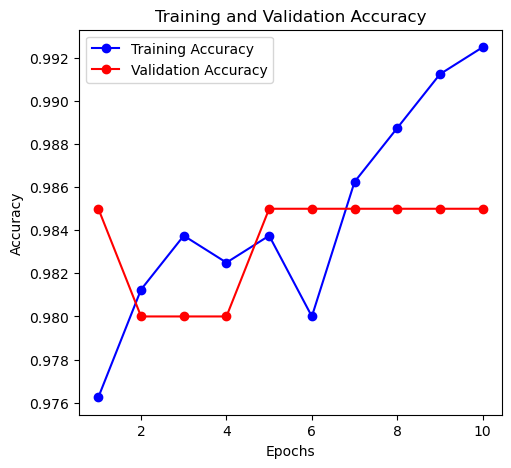

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


 Plot Loss

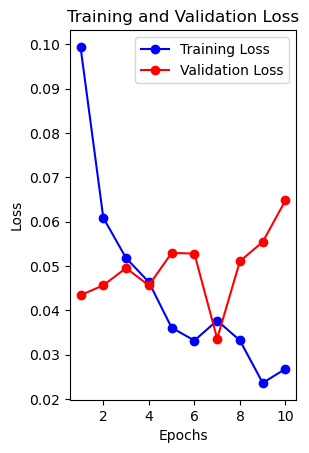

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print test results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert to label indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to label indices


## Test fine tuned model

In [ ]:
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)  # Load image
    img = cv2.resize(img, target_size)  # Resize to match model input
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [ ]:
def predict_image_probs(image_path, model, labels, target_size):
    """Returns probabilities for all classes."""
    img = preprocess_image(image_path, target_size)
    predictions = model.predict(img, verbose=0)[0]  # Get probabilities
    return {labels[i]: float(predictions[i]) for i in range(len(labels))}

def predict_image_label(image_path, model, labels, target_size=(299, 299)):
    """Returns the most probable label and the full probability dictionary."""
    prediction_dict = predict_image_probs(image_path, model, labels, target_size)
    max_label = max(prediction_dict, key=prediction_dict.get)
    return max_label, prediction_dict  # Return both in one function call

### Test images functions

Get images from the dataset [Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images](https://data.mendeley.com/datasets/rscbjbr9sj/3) Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.



In [ ]:


# Define folders
folder_path1 = "../data/ZhangLabData/CellData/OCT/test"
folder_path2 = "../data/OCT2017/OCT2017/test"

# Initialize lists
image_paths = []
true_labels = []

# Función para agregar imágenes desde un folder
def add_images_from_folder(folder_path):
    for label in os.listdir(folder_path):  # Each subfolder is a label
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.endswith(".jpeg"):
                    image_paths.append(os.path.join(label_path, img_name))
                    true_labels.append(label)

# Agrega imágenes de ambos folders
add_images_from_folder(folder_path1)
add_images_from_folder(folder_path2)

# Verificación
print(f"Total images: {len(image_paths)}")
print(f"Sample labels: {set(true_labels)}")


Total images: 2000
Sample labels: {'CNV', 'NORMAL', 'DRUSEN', 'DME'}


### Test model on test dataset

In [ ]:
# Lists to store ground truth and predictions
y_true1 = []
y_pred1 = []

# Loop through each image, preprocess it, and make predictions
for img_path, true_label in zip(image_paths, true_labels):
    predicted_label, predicted_probs = predict_image_label(img_path, model1, labels)

    # Store results for evaluation
    y_true1.append(true_label)  # Ground truth label
    y_pred1.append(predicted_label)  # Predicted label

# Convert labels to numerical format
y_true_numeric1 = [labels.index(label) for label in y_true1]  # Convert class names to indices
y_pred_numeric1 = [labels.index(label) for label in y_pred1]


### See results

In [ ]:

def evaluate_classification_results(y_true, y_pred, labels, output_dir):
    """
    Evaluate classification results and save metrics, report, and confusion matrix.

    Parameters:
    - y_true: list or array of true class labels (numeric or string)
    - y_pred: list or array of predicted class labels (numeric or string)
    - labels: list of label names in the correct order
    - output_dir: path to the folder where output files should be saved
    """
    os.makedirs(output_dir, exist_ok=True)

    # Compute total images
    total_images = len(y_true)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    metrics = {
        "Total Images": total_images,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    # Save metrics to JSON
    with open(os.path.join(output_dir, "metrics_post.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    print(json.dumps(metrics, indent=4))

    # Save classification report
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    with open(os.path.join(output_dir, "classification_report_post.json"), "w") as f:
        json.dump(report, f, indent=4)
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(output_dir, "confusion_matrix_post.png"))
    plt.close()


In [ ]:
evaluate_classification_results(y_true_numeric1, y_pred_numeric1, labels, "../results/finetuned/model1_evaluation")

## Save model

In [ ]:
model.save("../models/fine_tuned_xception.h5")